<a href="https://colab.research.google.com/github/PriyamvadaSingh-B/EXPLAINABLE-AI-B-45/blob/main/XAI_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

# Load the dataset
file_path = "/content/predictive_maintenance.csv"
df = pd.read_csv(file_path)

# Basic info about dataset
df_info = df.info()
df_head = df.head()
df_desc = df.describe(include="all")

df.shape, df_head, df_desc.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


((10000, 10),
    UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
 0    1     M14860    M                298.1                    308.6   
 1    2     L47181    L                298.2                    308.7   
 2    3     L47182    L                298.1                    308.5   
 3    4     L47183    L                298.2                    308.6   
 4    5     L47184    L                298.2                    308.7   
 
    Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
 0                    1551         42.8                0       0   No Failure  
 1                    1408         46.3                3       0   No Failure  
 2                    1498         49.4                5       0   No Failure  
 3                    1433         39.5                7       0   No Failure  
 4                    1408         40.0                9       0   No Failure  ,
             UDI Product ID   Type  Air temperature [K]  \
 count

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor

# ---------------- Load dataset ----------------
df = pd.read_csv("/content/predictive_maintenance.csv")

# Replace with your target column
target = "Target"

# Handle categorical features and drop irrelevant columns
X = df.drop(columns=[target, "Product ID", "Failure Type"])
X = pd.get_dummies(X, columns=["Type"], drop_first=True)
y = df[target]

# ---------------- Train/Test Split ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y if len(y.unique()) <= 10 else None
)

# ---------------- Choose task ----------------
task = "regression"   # change to "regression" if regression problem
model_name = "RandomForest"  # Options: RandomForest, Linear, XGBoost

# ---------------- Model Selection ----------------
if task == "classification":
    if model_name == "RandomForest":
        model = RandomForestClassifier(n_estimators=200, random_state=42)
    elif model_name == "Logistic":
        model = LogisticRegression(max_iter=1000, random_state=42)
    elif model_name == "XGBoost":
        model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

elif task == "regression":
    if model_name == "RandomForest":
        model = RandomForestRegressor(n_estimators=200, random_state=42)
    elif model_name == "Linear":
        model = LinearRegression()
    elif model_name == "XGBoost":
        model = XGBRegressor(random_state=42)

# ---------------- Train Model ----------------
model.fit(X_train, y_train)

# ---------------- Evaluation ----------------
if task == "classification":
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    print("Classification Metrics:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, zero_division=0))
    print("Recall:", recall_score(y_test, y_pred, zero_division=0))
    print("F1 Score:", f1_score(y_test, y_pred, zero_division=0))
    if y_prob is not None:
        print("ROC AUC:", roc_auc_score(y_test, y_prob))

elif task == "regression":
    y_pred = model.predict(X_test)

    print("Regression Metrics:")
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    # Avoid division by zero in MAPE calculation
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print("MAPE:", mape if not np.isinf(mape) else "Undefined")
    print("R² Score:", r2_score(y_test, y_pred))

Regression Metrics:
MSE: 0.0110438375
RMSE: 0.10508966409690346
MAE: 0.022917500000000004
MAPE: Undefined
R² Score: 0.6637487060041407


Shape of shap_values: (200, 8)
Shape of shap_values[i,:]: (8,)


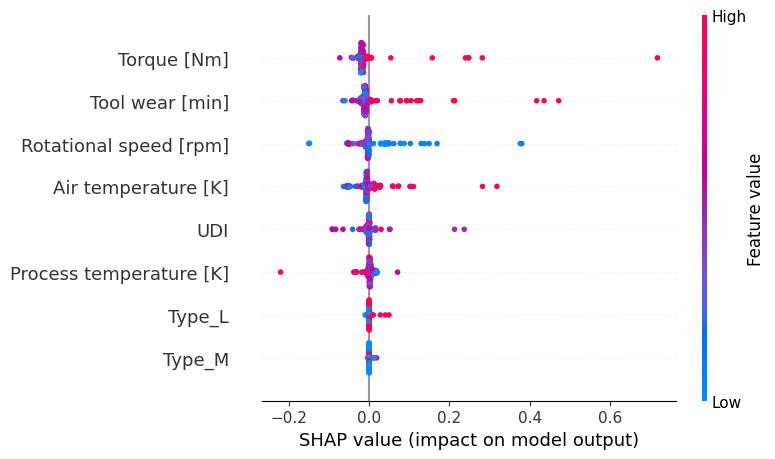

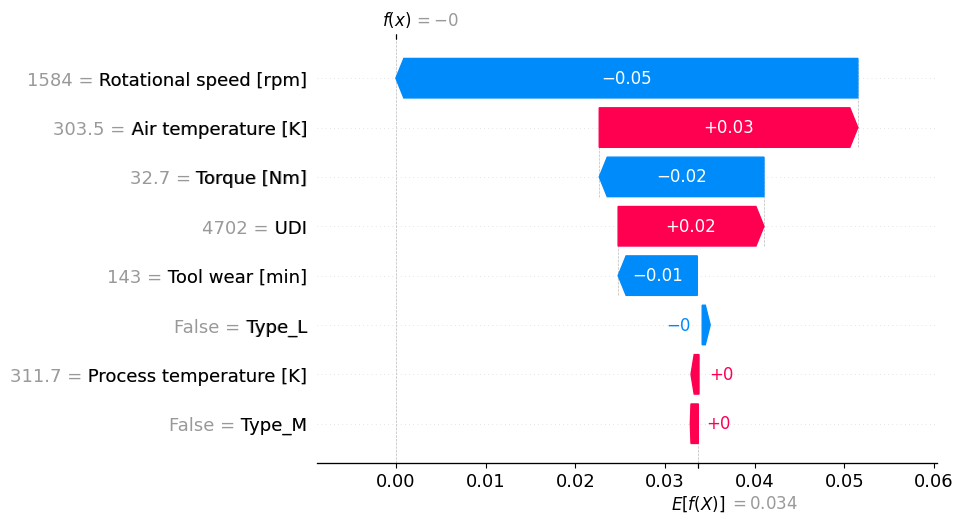

In [14]:
# ---------------- Install SHAP (if not already installed) ----------------
# pip install shap

import shap
import matplotlib.pyplot as plt

# ---------------- Select Explainer ----------------
# For tree-based models (RandomForest, XGBoost, LightGBM)
explainer = shap.TreeExplainer(model)   # model is your trained classifier/regressor

# For linear or black-box models (Logistic Regression, Neural Nets etc.)
# explainer = shap.KernelExplainer(model.predict, shap.sample(X_train, 100))

# ---------------- Compute SHAP values ----------------
# Use a subset of test data for speed
X_sample = X_test.sample(200, random_state=42) if len(X_test) > 200 else X_test

shap_values = explainer.shap_values(X_sample)

print("Shape of shap_values:", shap_values.shape)
print("Shape of shap_values[i,:]:", shap_values[i,:].shape)

# ---------------- Visualizations ----------------
# 1. Summary Plot (overall feature importance)
plt.figure()
shap.summary_plot(shap_values, X_sample, show=True)

# 2. Force Plot (explanation for first prediction)
shap.initjs()
i = 0
force_plot = shap.force_plot(explainer.expected_value, shap_values[i,:], X_sample.iloc[i,:])
shap.save_html("shap_force_plot.html", force_plot)   # saves interactive HTML

# 3. Waterfall Plot (step-by-step feature contributions for one instance)
plt.figure()
shap.waterfall_plot(shap.Explanation(values=shap_values[i,:],
                                       base_values=explainer.expected_value,
                                       data=X_sample.iloc[i,:],
                                       feature_names=X_sample.columns.tolist())) # Convert index to list
plt.show()